# YT 2020: IR Testing

Перепроверить расчеты можно тут https://yt.yandex-team.ru/hahn/resource-planner/ 

In [1]:
# обязательный импорт для каждого питонячего ноутбука
PATH_REGEXP = r'(preorder/v\d+apr)'
DEFAULT_KEY = None#'ent_test'
import os
import re
import sys
import logging
from pathlib import Path
cwd = os.getcwd()
preorder_key = max(re.findall(PATH_REGEXP, cwd))
capacity_path = Path(cwd[:cwd.rfind(preorder_key)])
sys.path.extend([str(capacity_path), str(capacity_path / preorder_key), str(capacity_path / ("../" * 4))])

%store -r external_data
try:
    if external_data is None:
        external_data = dict()
except NameError as e:
    external_data = dict()

start_key = external_data.get('start_key', DEFAULT_KEY)

import market.sre.tools.capacity.lib.tools as tools
tools.set_start_key(start_key)

no stored variable or alias external_data


Deprecated self-made module, try to use https://yt.yandex-team.ru/docs/description/chyt/cli_and_api


In [2]:
import pandas as pd
import numpy as np
from pprint import pformat
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

%matplotlib inline

import warnings
warnings.simplefilter("ignore", UserWarning)

In [3]:
from market.sre.tools.capacity.lib.YT.Cluster import Cluster
from market.sre.tools.capacity.lib.tools import today
from market.sre.tools.capacity.preorder.v2020apr.preorder_lib.core.predictor import Formula, Feature, FormulaStrategy, Predictor, Window
from market.sre.tools.capacity.preorder.v2020apr.input_data.YT_accounts import arnold_accounts, hahn_accounts, seneca_sas_accounts, seneca_man_accounts, seneca_vla_accounts
from market.sre.tools.capacity.preorder.v2020apr.input_data.YT_pools import hahn_pools_list, hahn_pools_dict, arnold_pools_list, arnold_pools_dict
from market.sre.tools.capacity.preorder.v2020apr.additional.YT.disk_forecaster import get_disk_forecast
from market.sre.tools.capacity.preorder.v2020apr.additional.YT.cpu_forecaster import get_cpu_forecast
from market.sre.tools.capacity.preorder.v2020apr.preorder_lib.yt.yt_order import YTOrderRequestFile, YTOrderRequestFileItem, YtOrderRequestFileItemDiskQuota, YtOrderRequestFileItemCpuQuota, YtOrderRequestFileItemDTQuota
from market.sre.tools.capacity.preorder.v2020apr.preorder_lib.core.types.department import Department
from market.sre.tools.capacity.preorder.v2020apr.preorder_lib.core.department_info import DepartmentInfo
from market.sre.tools.capacity.preorder.v2020apr.preorder_lib.core.types.cloud import Cloud
from market.sre.tools.capacity.preorder.v2020apr.preorder_lib.core.types.reason import Reason
from market.sre.tools.capacity.preorder.v2020apr.preorder_lib.core.types.deadline import Deadline
from market.sre.tools.capacity.preorder.v2020apr.preorder_lib.core.types.platform import Platform
from market.sre.tools.capacity.preorder.v2020apr.preorder_lib.core.resources_info import ResourcesInfo
from market.sre.tools.capacity.preorder.v2020apr.additional.YT.tools import clean_YT_account

## Настройки

In [4]:
# paramaters add tag here
forecast_start_date = "2020-07-01"
forecast_end_date = "2020-08-01"
history_start_date = "2020-04-01"
history_end_date = "2020-05-01"
dau_white = 5500000
dau_blue = 4000000
offers_white = 2000000
offers_blue = 0
orders_blue = 0
dc_minus_one = True
gencfg_dir = '2020-05'
service_file_name='indexer'
department='INDEXER'
service_key_words = ['indexer']
preorder_id='aug20'
out_dir='out/yt'
revision_number='current'
kpi_key=None

In [5]:
# Parameters
src_file_name = "ir_testing"
service_file_name = "ir_testing"
service_key_words = ["production"]
department = "IR"
forecast_start_date = "2021-02-01"
forecast_end_date = "2022-06-01"
history_start_date = "2019-01-01"
history_end_date = "2021-01-01"
dau_white = 8700000
dau_blue = 42
offers_white = 1300000000
offers_blue = 42
orders_blue = "248974"
kpi_key = "dw_8700000_db_42_ofw_1300000000_ofb_42_orb_248974"
dc_minus_one = "True"
out_dir = "out/preorder/yt"
gencfg_dir = "v2021_02/"
previous_kpi_key = "dw_8700000_db_42_ofw_1300000000_ofb_42_orb_248974"
revision_number = "dw_8700000_db_42_ofw_1300000000_ofb_42_orb_248974/2022-06-01"
df_dir = "out/preorder/yt/dw_8700000_db_42_ofw_1300000000_ofb_42_orb_248974/2022-06-01/dataframes"


In [6]:
# откуда смотреть историю потребления
date_start = history_start_date
date_end =history_end_date
forecast_date = forecast_end_date
result_dir = out_dir
start_key=kpi_key
tools.set_start_key(start_key)
target_dir = capacity_path / preorder_key / f"additional/RTC/src/{out_dir}/{revision_number}/dataframes"

# verbose
verbose = True

# учитывать ли пики в пуле?
consider_peaks = False

# grid
grid=True

tail_depth = 7
quantile = .8

# formula
formula = None

# formula stratery
formula_strategy = FormulaStrategy.FIRST

# настройки Predictor'а
decreasing_base_function = 'mean'
decreasing_reserve = 1
features = [Feature.OFFERS_COUNT]

# defaults
default_platform = Platform.INFRA
default_department = Department.IR

notebook_filename = f"https://a.yandex-team.ru/arc/trunk/arcadia/market/sre/tools/capacity/{preorder_key}/additional/FORECAST/YT/ir_testing.ipynb"
notebook_filename

'https://a.yandex-team.ru/arc/trunk/arcadia/market/sre/tools/capacity/preorder/v2020apr/additional/FORECAST/YT/ir_testing.ipynb'

In [7]:
whois = ResourcesInfo(capacity_path / preorder_key / "input_data/files/whois", default_platform=default_platform, default_department=default_department)

In [8]:
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['grid.color'] = 'k'
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['figure.dpi'] = 80
plt.rcParams['savefig.dpi'] = 100

grid = True

In [9]:
predictor = Predictor()

### Env

In [10]:
env = 'production' # будем смотреть не продакшен

## Disk

#### Accounts

In [11]:
label = '-ir'

_hahn_accounts = [account for account in hahn_accounts if label in account and account not in [account for account in hahn_accounts if label in account and env in account]]
_arnold_accounts = [account for account in arnold_accounts if label in account and account not in [account for account in arnold_accounts if label in account and env in account]]
_seneca_sas_accounts = [account for account in seneca_sas_accounts if label in account and account not in [account for account in seneca_sas_accounts if label in account and env in account]]
_seneca_man_accounts = [account for account in seneca_man_accounts if label in account and account not in [account for account in seneca_man_accounts if label in account and env in account]]
_seneca_vla_accounts = [account for account in seneca_vla_accounts if label in account and account not in [account for account in seneca_vla_accounts if label in account and env in account]]

cluster_accounts = {
    Cluster.HAHN: _hahn_accounts,
    Cluster.ARNOLD: _arnold_accounts,
    Cluster.SENECA_SAS: _seneca_sas_accounts,
    Cluster.SENECA_MAN: _seneca_man_accounts,
    Cluster.SENECA_VLA: _seneca_vla_accounts,
}

print(cluster_accounts)

{<Cluster.HAHN: 'hahn'>: ['market-ir-development', 'market-ir-prestable', 'market-ir-testing'], <Cluster.ARNOLD: 'arnold'>: ['market-ir-development', 'market-ir-prestable', 'market-ir-testing'], <Cluster.SENECA_SAS: 'seneca-sas'>: [], <Cluster.SENECA_MAN: 'seneca-man'>: [], <Cluster.SENECA_VLA: 'seneca-vla'>: []}


##### Disk usage history and forecast, GB

HAHN DEFAULT usage: 0 / 51610 Gb = 0.0 %


/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(
/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(


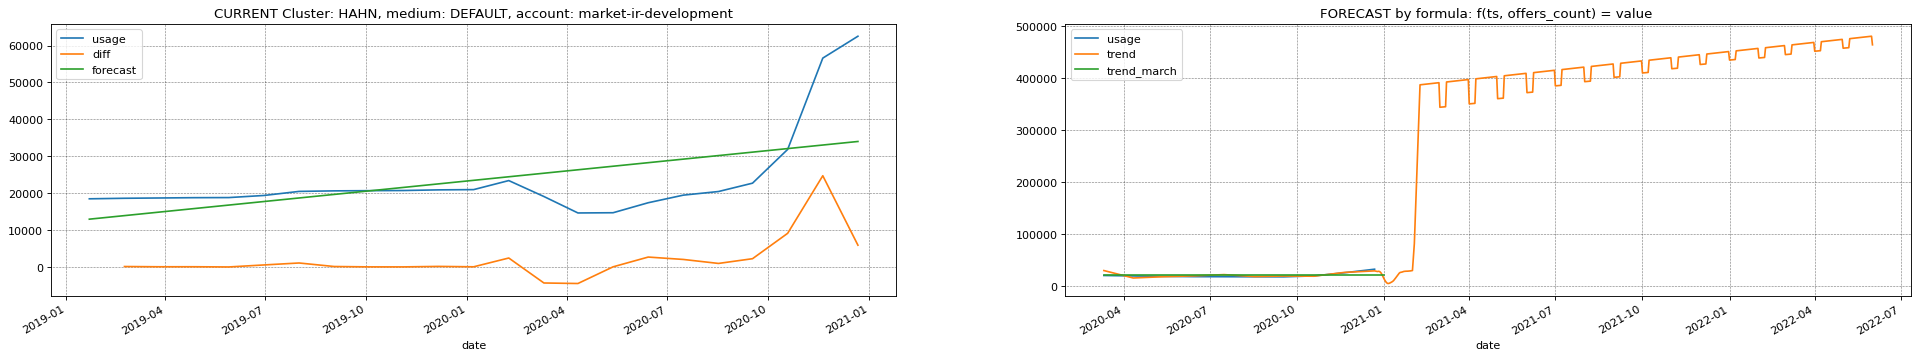

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: 0.8283425358070676}


/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(
/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(


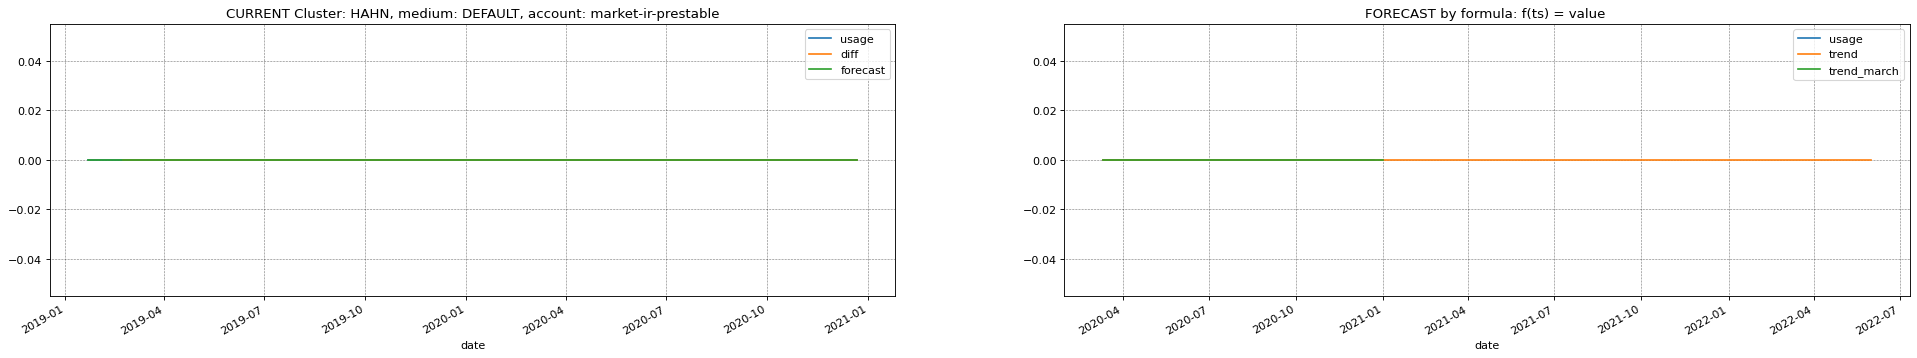

Correlations: {<Formula.F_TS_OFFERS_eq_DIFF: 'f(ts, offers_count) = diff'>: nan,
 <Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: nan}


/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(
/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(


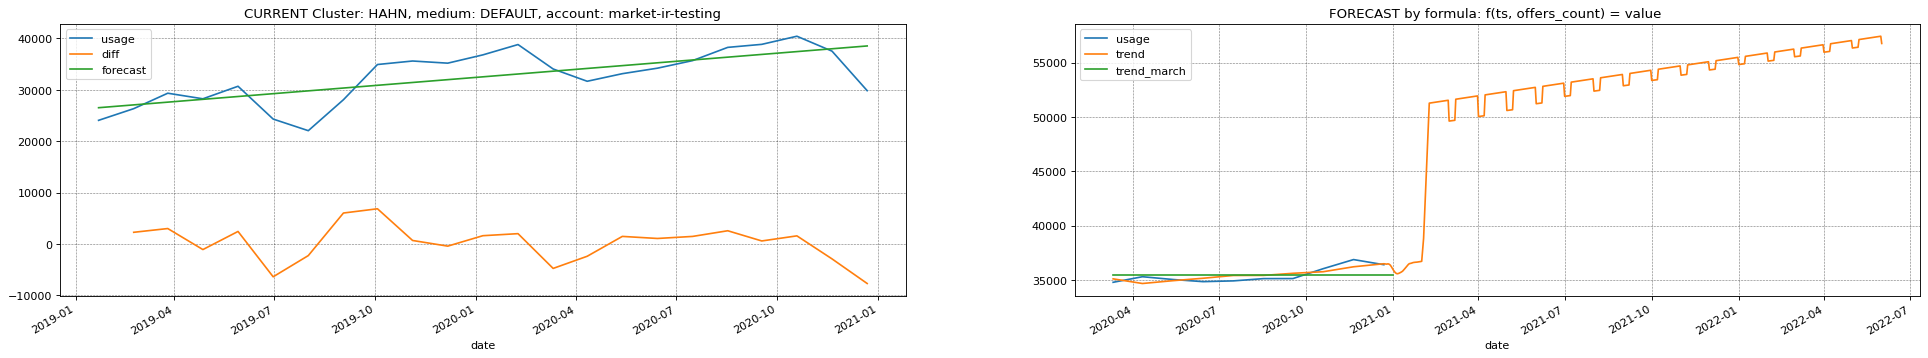

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: 0.7831172976233143}


HAHN SSD usage: 4 / 300 Gb = 1.33 %


/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(
/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(


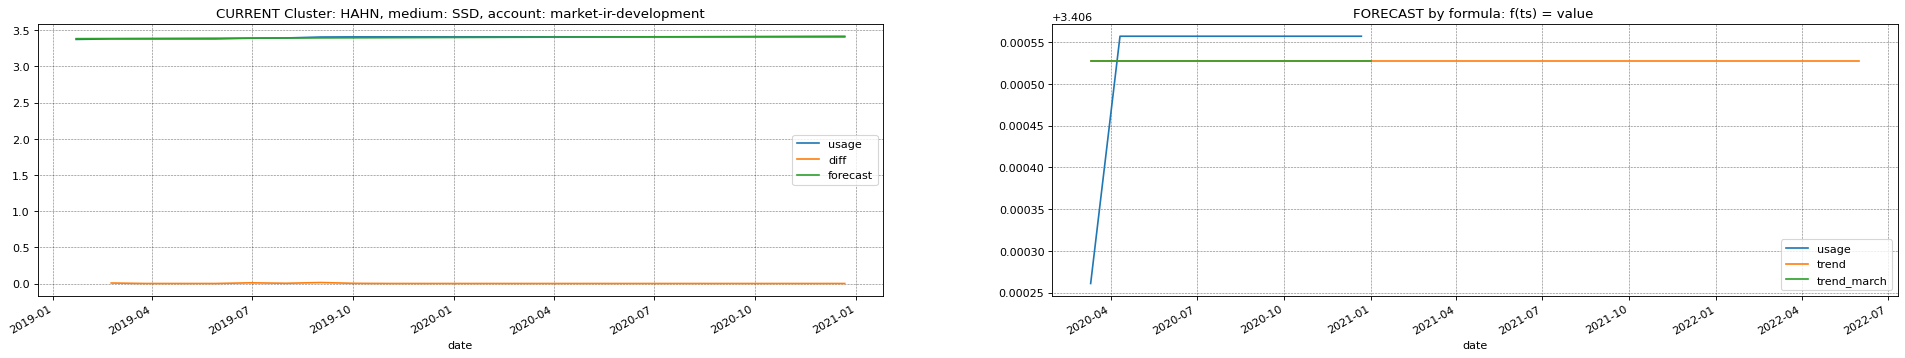

Correlations: {<Formula.F_TS_OFFERS_eq_DIFF: 'f(ts, offers_count) = diff'>: -0.5274010873730909,
 <Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: nan}


/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(
/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(


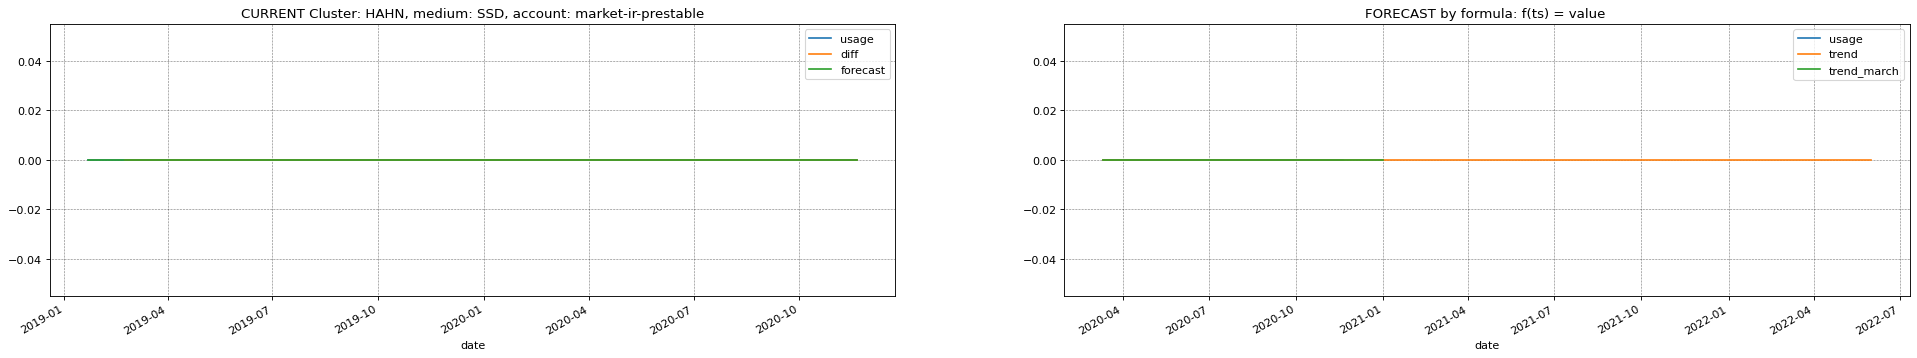

Correlations: {<Formula.F_TS_OFFERS_eq_DIFF: 'f(ts, offers_count) = diff'>: nan,
 <Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: nan}


/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(
/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(


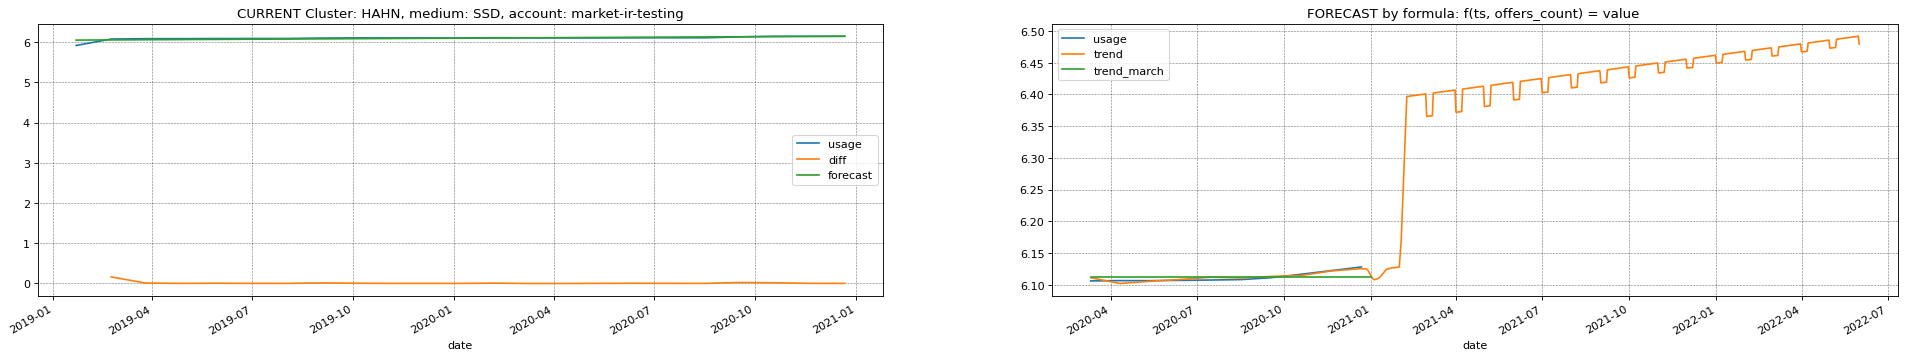

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: 0.9311909272860965}


ARNOLD DEFAULT usage: 0 / 25600 Gb = 0.0 %


/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(
/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(


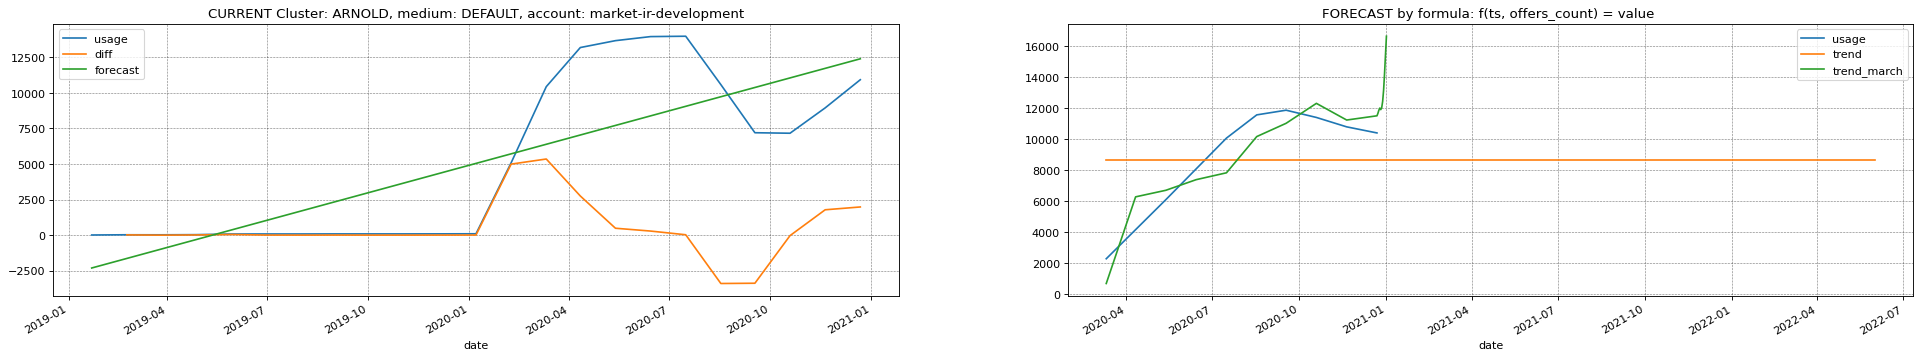

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: 0.6542566484982318}


/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(
/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(


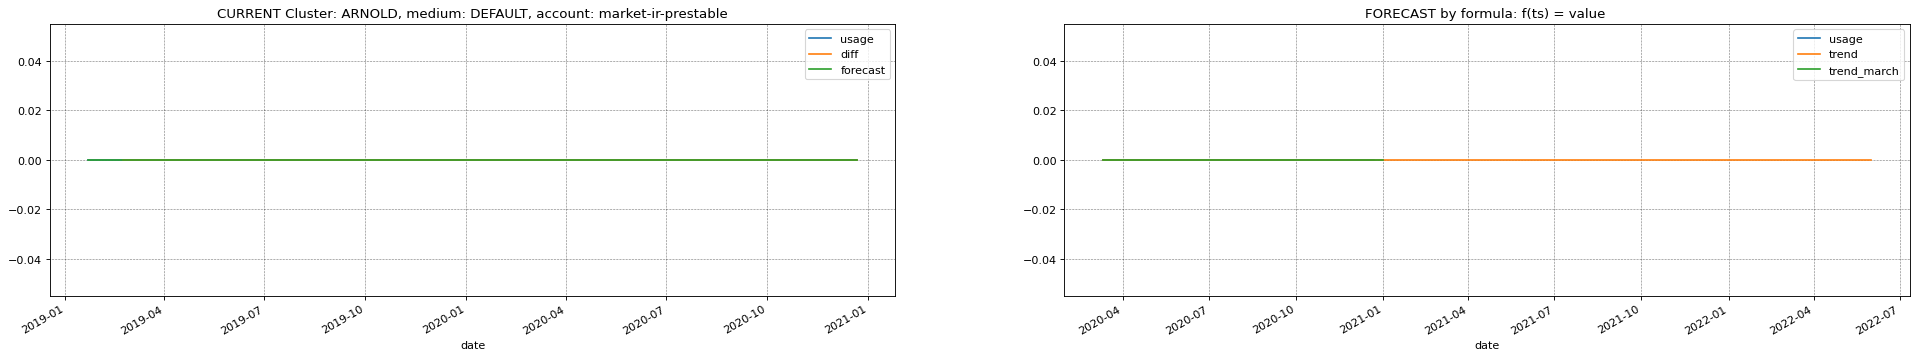

Correlations: {<Formula.F_TS_OFFERS_eq_DIFF: 'f(ts, offers_count) = diff'>: nan,
 <Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: nan}


/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(


/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(


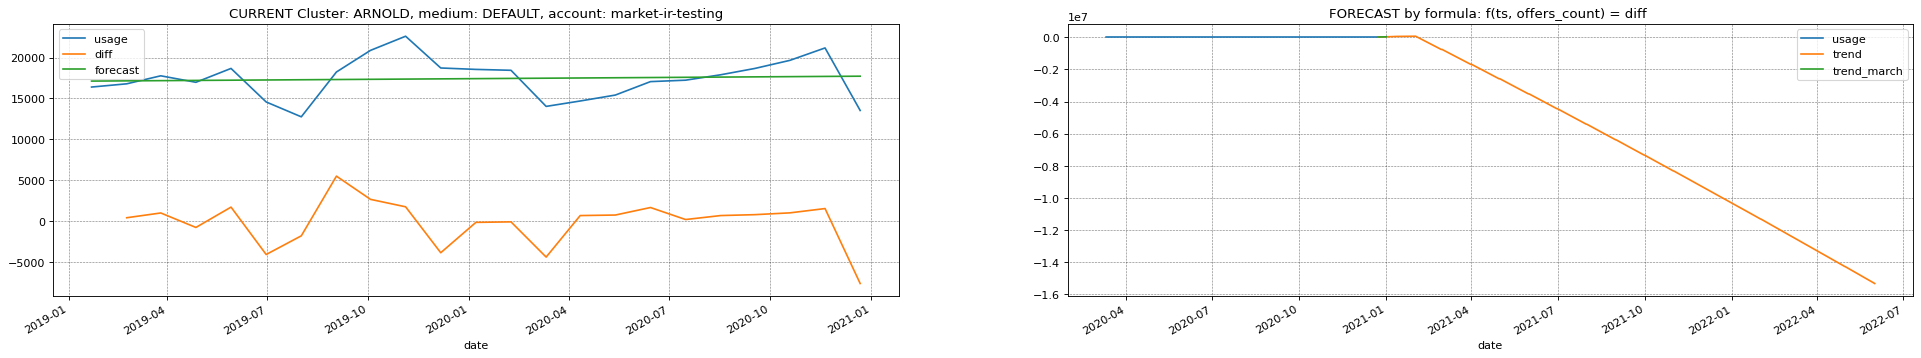

Correlations: {<Formula.F_TS_OFFERS_eq_DIFF: 'f(ts, offers_count) = diff'>: 0.5349979453101723,
 <Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: 0.19723930636900344}


ARNOLD SSD usage: 1 / 50 Gb = 2.0 %


/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(
/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(


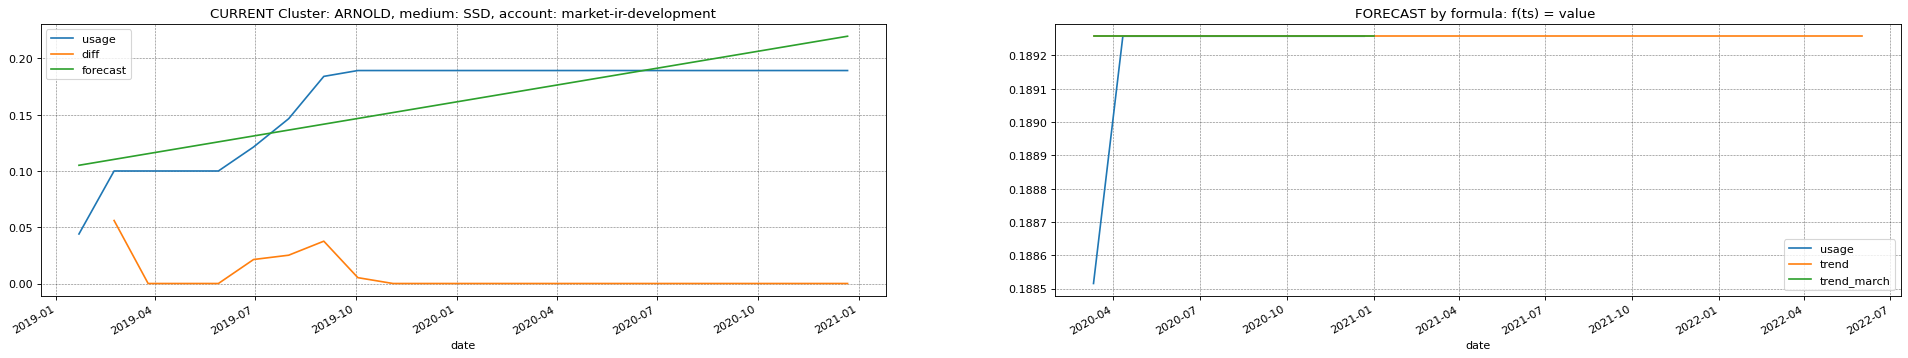

Correlations: {<Formula.F_TS_OFFERS_eq_DIFF: 'f(ts, offers_count) = diff'>: -0.5274010873730911,
 <Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: nan}


/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(
/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(


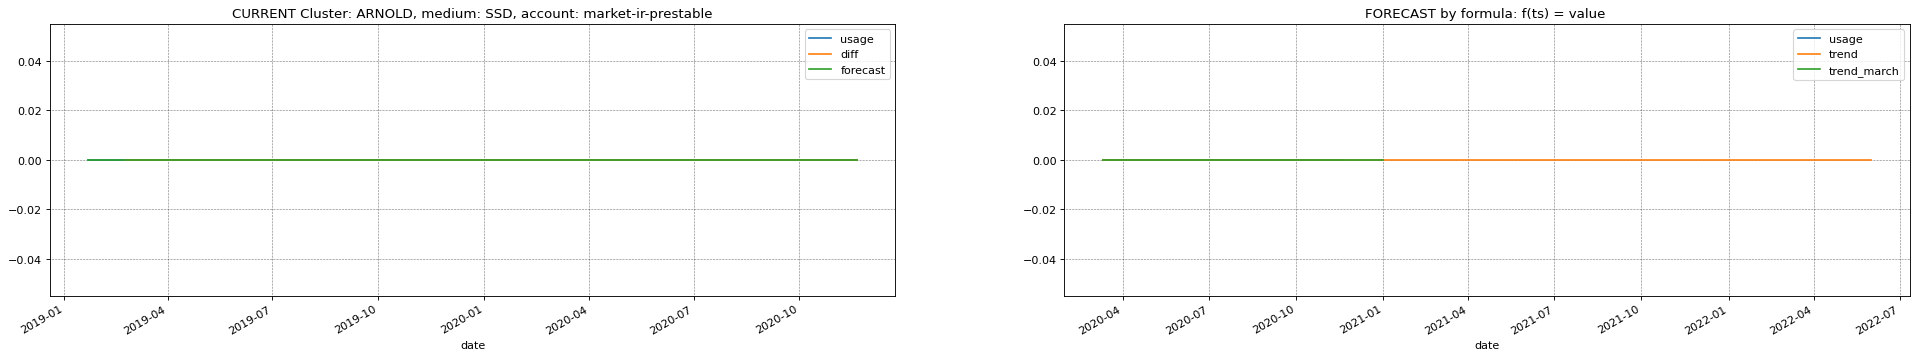

Correlations: {<Formula.F_TS_OFFERS_eq_DIFF: 'f(ts, offers_count) = diff'>: nan,
 <Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: nan}


/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(
/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(


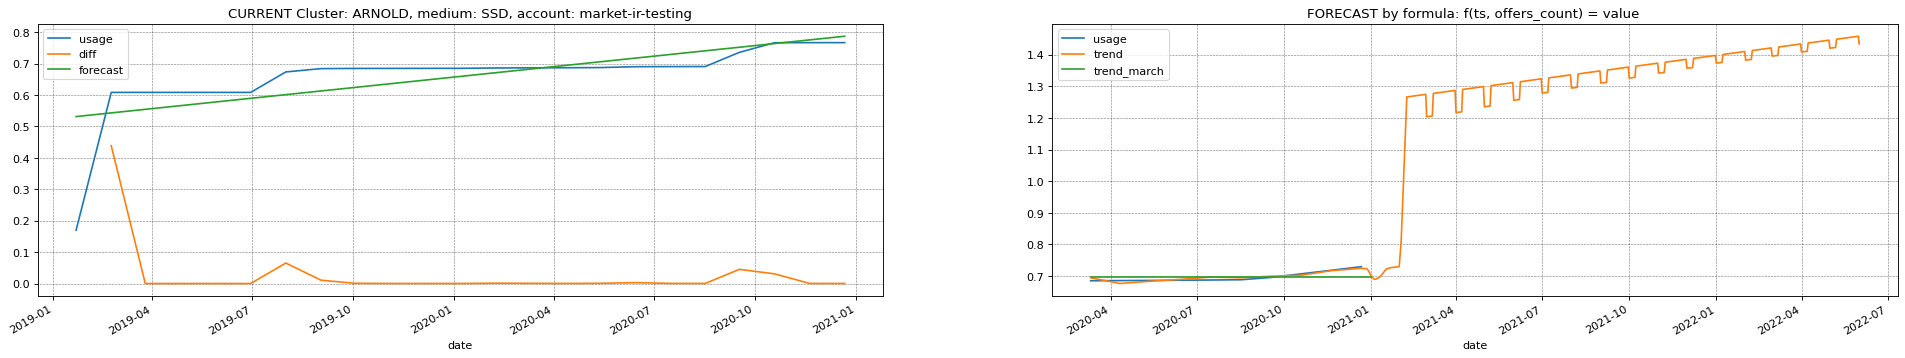

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: 0.9288143414850857}


In [12]:
disk_forecast = get_disk_forecast(predictor=predictor,
                                  formula=formula,
                                  formula_strategy=formula_strategy,
                                  features=features,
                                  window=Window(),
                                  decreasing_base_function=decreasing_base_function,
                                  decreasing_reserve=decreasing_reserve,
                                  cluster_accounts=cluster_accounts,
                                  date_start=date_start,
                                  date_end=date_end,
                                  verbose=verbose,
                                  grid=grid,
                                  forecast_end_date=forecast_date
                                 )

In [13]:
disk_forecast_df = pd.DataFrame(disk_forecast).set_index(['cluster', 'account', 'medium'])
disk_forecast_df

predicted_usage_gb      reason  \
cluster account               medium                                    
HAHN    market-ir-development DEFAULT              364335      OFFERS   
        market-ir-prestable   DEFAULT                   0  CUMULATIVE   
        market-ir-testing     DEFAULT               52715      OFFERS   
        market-ir-development SSD                       4  CUMULATIVE   
        market-ir-prestable   SSD                       0  CUMULATIVE   
        market-ir-testing     SSD                       7      OFFERS   
ARNOLD  market-ir-development DEFAULT                8666      OFFERS   
        market-ir-prestable   DEFAULT                   0  CUMULATIVE   
        market-ir-testing     DEFAULT               66091      OFFERS   
        market-ir-development SSD                       1  CUMULATIVE   
        market-ir-prestable   SSD                       0  CUMULATIVE   
        market-ir-testing     SSD                       2      OFFERS   

                                       usage_gb  quota_gb  \
cluster account               medium                        
HAHN    market-ir-development DEFAULT     62518     76800   
        market-ir-prestable   DEFAULT         0      1024   
        market-ir-testing     DEFAULT     29833     51610   
        market-ir-development SSD             4        50   
        market-ir-prestable   SSD             0         0   
        market-ir-testing     SSD             7       300   
ARNOLD  market-ir-development DEFAULT     10925     25600   
        market-ir-prestable   DEFAULT         0      1024   
        market-ir-testing     DEFAULT     13524     51610   
        market-ir-development SSD             1        50   
        market-ir-prestable   SSD             0         0   
        market-ir-testing     SSD             1       300   

                                                                                   trend  
cluster account               medium                                                      
HAHN    market-ir-development DEFAULT  {"trend":{"1583884800000":30434.3630546385,"15...  
        market-ir-prestable   DEFAULT  {"trend":{"1583884800000":0.0,"1586563200000":...  
        market-ir-testing     DEFAULT  {"trend":{"1583884800000":35094.7729782379,"15...  
        market-ir-development SSD      {"trend":{"1583884800000":3.4065273859,"158656...  
        market-ir-prestable   SSD      {"trend":{"1583884800000":0.0,"1586563200000":...  
        market-ir-testing     SSD      {"trend":{"1583884800000":6.1111260053,"158656...  
ARNOLD  market-ir-development DEFAULT  {"trend":{"1583884800000":8665.0163713177,"158...  
        market-ir-prestable   DEFAULT  {"trend":{"1583884800000":0.0,"1586563200000":...  
        market-ir-testing     DEFAULT  {"trend":{"1583884800000":null,"1586563200000"...  
        market-ir-development SSD      {"trend":{"1583884800000":0.1892576348,"158656...  
        market-ir-prestable   SSD      {"trend":{"1583884800000":0.0,"1586563200000":...  
        market-ir-testing     SSD      {"trend":{"1583884800000":0.6947362949,"158656...

In [14]:
from market.sre.tools.capacity.preorder.v2020apr.additional.RTC.src.forecast.ForecastDAO import ForecastDAO, ForecastTable

forecast_dto = []

for key, value in disk_forecast_df.iterrows():
    cluster, account, medium = key
    predicted_usage_gb = value.predicted_usage_gb
    quota_gb = value.quota_gb
    usage_gb = value.usage_gb
    reason = value.reason
    
    if medium == 'DEFAULT':
        disk_quota=YtOrderRequestFileItemDiskQuota(
            accounts=[account],
            hdd_quota_gb=quota_gb,
            hdd_usage_gb=usage_gb,
            predicted_hdd_usage_gb=predicted_usage_gb
        )
    elif medium == 'SSD':
        disk_quota=YtOrderRequestFileItemDiskQuota(
            accounts=[account],
            ssd_quota_gb=quota_gb,
            ssd_usage_gb=usage_gb,
            predicted_ssd_usage_gb=predicted_usage_gb
        )
    else:
        raise
    
    resource_info = whois.get_info(Cloud.YT, clean_YT_account(account))
    department_info = DepartmentInfo.from_file(capacity_path / preorder_key / 'input_data/orders', resource_info['department'])
    file_item = YTOrderRequestFileItem(cluster=Cluster.from_str(cluster), 
                                       dc=Cluster.from_str(cluster).get_dc(), 
                                       disk_quota=disk_quota)
    
    result_dir_path = capacity_path / preorder_key / result_dir / (f"{resource_info['department']}/{Cloud.YT}")
    Path(result_dir_path).mkdir(parents=True, exist_ok=True)
    file_path = result_dir_path / (f"disk-{cluster}-{account}-{medium}.yaml")
    
    
    YTOrderRequestFile(
        department=resource_info['department'],
        cloud=Cloud.YT,
        platform=resource_info['platform'],
        ticket='',
        contacts={},
        deadline=Deadline.EVENLY,
        items=[file_item],
        file_path=str(target_dir / f'{service_file_name}_disk.yaml'),
        reason=Reason.from_str(reason),
        generated=True,
        source_meta={'kpi': kpi_key}).dump_to_file()
    forecast_disk=ForecastDAO(
            metric = str(medium),
            environment = str(account.split('-')[-1]),
            kpi = kpi_key,
            cloud = "YT",
            abc_service = department_info.abc_slug,
            entity = str(account),
            forecast_start_date = forecast_start_date,
            forecast_end_date = forecast_end_date,
            history_start_date = history_start_date,
            history_end_date = history_end_date,
            result_df = value.trend,
            result_by_date = predicted_usage_gb if not np.isnan(predicted_usage_gb) else 0,
            preorder_id = 'feb21',
            source_meta = {'cluster': cluster}
        )
    forecast_dto.append(forecast_disk)
ForecastDAO.save_forecast(client = ForecastDAO.get_client(), forecasts=forecast_dto, table=ForecastTable('yt_accounts').get_forecast_table_path())

In [15]:
df = disk_forecast_df.rename(columns={
                   'quota': 'current_allocation', 
                   'predicted_usage_gb': 'future_allocation',
                    'reason': 'correlation'}).reset_index()
df['service'] = df['cluster'] + '_' + df['account'] + '_' + df['medium']
df.to_json(target_dir / f'{service_file_name}_disk.json')

### CPU

In [16]:
hahn_pools_list, arnold_pools_list

(['market-root',
  'market-money',
  'market-dco',
  'market-testing-yamarec',
  'market-testing',
  'market-testing-indexer',
  'market-testing-batch',
  'market-testing-priority',
  'market-testing-mbo-extractors',
  'market-production-mstat-tm-testing',
  'market-replenishment-testing',
  'market-research',
  'market-reserve',
  'market-production',
  'market-production-indexer',
  'market-production-indexer-white',
  'picrobot',
  'idx2yt',
  'genlog',
  'indexation',
  'market-production-indexer-yellow',
  'translator',
  'market-production-indexer-blue',
  'snippets2ferryman',
  'market-production-indexer-red',
  'market-production-compress-batch',
  'market-production-batch',
  'market-production-analytics-platform',
  'market-production-mstat-tm',
  'market-production-mstat-dictionaries-tm',
  'market-production-mstat-actions-tm',
  'market-production-mstat-olap2-etl-tm',
  'market-production-priority',
  'market-production-priority-common',
  'market-production-priority-analys

In [17]:
label = '-ir'

_hahn_pools_list = [pool for pool in hahn_pools_list if label in pool and env in pool]
_arnold_pools_list = [pool for pool in arnold_pools_list if label in pool and env in pool]

cluster_pools = {
    Cluster.HAHN: _hahn_pools_list,
    Cluster.ARNOLD: _arnold_pools_list
}

print(cluster_pools)

{<Cluster.HAHN: 'hahn'>: ['market-production-mbo-ir-tms-common', 'market-production-mbo-ir-tms-saas'], <Cluster.ARNOLD: 'arnold'>: ['market-production-mbo-ir-tms-common', 'market-production-mbo-ir-tms-saas']}


У IR нет своих пулов.

In [18]:
# cpu_forecast = get_cpu_forecast(predictor=predictor,
#                                 cluster_pools=cluster_pools,
#                                 formula=formula,
#                                 formula_strategy=formula_strategy,
#                                 features=features,
#                                 window=Window(),
#                                 decreasing_base_function=decreasing_base_function,
#                                 decreasing_reserve=decreasing_reserve,
#                                 consider_peaks=consider_peaks,
#                                 date_start=date_start,
#                                 date_end=date_end,
#                                 peaks_window_1=5,
#                                 peaks_window_2=60,
#                                 verbose=verbose,
#                                 grid=grid,
#                                 tail_depth=tail_depth)

In [19]:
# cpu_forecast_df = pd.DataFrame(cpu_forecast).set_index(['cluster', 'pool'])
# cpu_forecast_df

In [20]:
# for key, value in cpu_forecast_df.query("predicted_usage > 0").iterrows():
#     cluster, pool = key
#     predicted_usage = value.predicted_usage
#     quota = value.quota
#     usage = value.usage
#     peak_coef = value.peak_coef
#     reason = value.reason
    
#     cpu_quota=YtOrderRequestFileItemCpuQuota(
#         pools=[pool],
#         cpu_quota=quota,
#         cpu_usage=usage,
#         predicted_cpu_usage=predicted_usage,
#         cpu_peak_coef=peak_coef
#     )
    
#     resource_info = whois.get_info(Cloud.YT, pool)
#     department_info = DepartmentInfo.from_file(capacity_path / preorder_key / 'input_data/orders', resource_info['department'])
#     file_item = YTOrderRequestFileItem(cluster=Cluster.from_str(cluster), 
#                                        dc=Cluster.from_str(cluster).get_dc(), 
#                                        cpu_quota=cpu_quota)
    
#     YTOrderRequestFile(
#         department=resource_info['department'],
#         cloud=Cloud.YT,
#         platform=resource_info['platform'],
#         ticket=notebook_filename,
#         contacts=department_info.owners if department_info else [],
#         deadline=Deadline.EVENLY,
#         items=[file_item],
#         file_path=str(capacity_path / preorder_key / (f"input_data/orders/{resource_info['department']}/{Cloud.YT}/pool-{cluster}-{pool}.yaml")),
#         reason=Reason.from_str(reason),
#         generated=True).dump_to_file()